In [105]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import h5py
from pathlib import Path    
import seaborn as sns

In [8]:
datapath = Path.cwd() / "results"

In [135]:
def rearrange_data(arr):
    res = np.swapaxes(arr,-1,0)
    res = np.swapaxes(res,-2,1)
    return res

def disorder_mean(A, n_samples = None):
    if n_samples is None:
        return np.mean(A,2)
    else:
        return np.mean(A[:,:,0:n_samples],2)

def disorder_std(A, n_samples = None):
    if n_samples is None:
        return np.std(A,2)
    else:
        return np.std(A[:,:,0:n_samples],2)

In [180]:
def idx_transgression(arr,threshold):
    idx = np.zeros(arr.shape[1],dtype=int)
    for j in range(arr.shape[1]):
        found = False
        for i in range(arr.shape[0]):
            if found == False and arr[i,j] >= threshold:
                idx[j] = i
                found = True
        if found == False:
            idx[j] = -1 #be careful that this never breaks things
    return idx

def safeguard_minusone(idx):
    res = np.zeros(idx.shape[0],dtype=float)
    for i in range(idx.shape[0]):
        res[i] = idx[i] if idx[i] != -1 else np.nan
    return res

def mask_transgression(arr,threshold):
    mask = np.zeros(arr.shape,dtype=bool)
    idx = idx_transgression(arr,threshold)
    for j in range(arr.shape[1]):
        if idx[j] != -1:
            mask[idx[j],j]=True
    return mask

In [199]:
def model(x,a,b,c):
    return a*x**b+c

In [186]:
F = 5
jobids = []
params = []
data = []
N = [14,15,16,17,18]
files = ["5173899_N14.jld2","5173900_N15.jld2","5173901_N16.jld2","5173902_N17.jld2","5173903_N18.jld2"]
for (i,file) in enumerate(files):
    with h5py.File(datapath/file,"r") as f:
        jobids.append(f["jobid"][()].decode("UTF-8"))
        params.append(f["params"][()])
        data.append(2-2*rearrange_data(f["data"][()]))
T = np.arange(0,5.1,0.1)
xcenter = 3

In [225]:
fn = 0
xvals = np.array([abs(pos-xcenter) for pos in range(1,N[fn]+1)])

In [235]:
thresholds = [0.25,0.5,0.75]#,1.0,1.25,1.5,1.75,2]
fit_params = []
fit_errs = []
tvals = []
for (i,th) in enumerate(thresholds):
    tvals.append(T[idx_transgression(data[fn][:,:,0,0],th)])
    popt, pcov = curve_fit(model,xvals,tvals[i])
    fit_params.append(popt)
    fit_errs.append(np.sqrt(np.diag(pcov)))

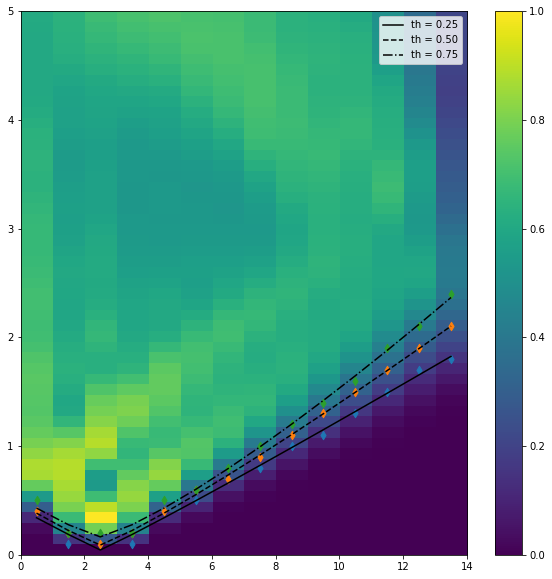

In [251]:
plt.figure(figsize=(10,10))
linestyles = ["-","--","-."]
plt.imshow(data[fn][:,:,0,0],cmap="viridis",origin="lower",aspect="auto",extent=[0,N[fn],0,T[-1]])
for (i,th) in enumerate(thresholds):
    plt.plot(np.arange(0,N[fn],1)+0.5,model(xvals,*fit_params[i]),label="th = {:.2f}".format(th),color="black",ls=linestyles[i])
    plt.scatter(np.arange(0,N[fn],1)+0.5,tvals[i], marker= "d")
plt.colorbar()
plt.legend()
plt.show()

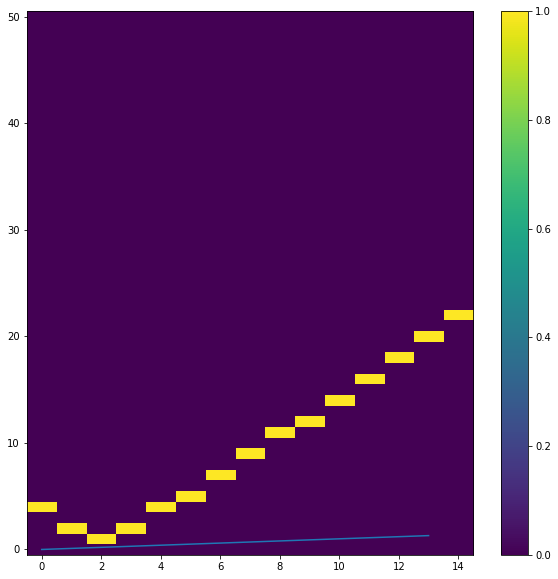

In [165]:
plt.figure(figsize=(10,10))
plt.imshow(mask_transgression(data[1][:,:,0,0],0.4),cmap="viridis",origin="lower",aspect="auto")
plt.plot(range(0,14),list(map(lambda x: 0.1*x,range(0,14))))
plt.colorbar()
plt.show()